# Dask


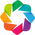

In [1]:
%load_ext memory_profiler
%load_ext snakeviz
%load_ext cython
import holoviews as hv
hv.extension('bokeh','matplotlib')
from IPython.core import debugger
ist = debugger.set_trace

We load in the position and box information created in the *intro* notebook. If you haven't run that notebook, this line will not work! (You don't have to read the wall of text, just run the cells...)

## Round 0: Dask Bag Sandbox

In [2]:
import numpy as np
num = 3
lmin = -25 #lower simulation box bound in x, y, and z
lmax = +25 #upper simulation box bound in x, y, and z

L = lmax - lmin
box = np.array([L,L,L])
pos = lmin + np.random.random((num,3))*(lmax-lmin)

lx = box[0]
ly = box[1]
lz = box[2]
lx2 = box[0]/2.0
ly2 = box[1]/2.0
lz2 = box[2]/2.0

print('Read {:d} positions.'.format(pos.shape[0]))
print('x min/max: {:+4.2f}/{:+4.2f}'.format(pos.min(0)[0],pos.max(0)[0]))
print('y min/max: {:+4.2f}/{:+4.2f}'.format(pos.min(0)[1],pos.max(0)[1]))
print('z min/max: {:+4.2f}/{:+4.2f}'.format(pos.min(0)[2],pos.max(0)[2]))

Read 3 positions.
x min/max: -24.76/+7.03
y min/max: -24.77/+23.55
z min/max: -23.63/+2.23


In [3]:
from math import cos,pi,sqrt
import numpy as np
import dask.bag as db
import dask

def potentialEnergyFunk(r,width=1.0,height=10.0):
    '''
    Calculates the (soft) potential energy between two atoms
    
    Parameters
    ----------
    r: float
        separation distance between two atoms
    height: float
        breadth of the potential i.e. where the potential goes to zero
    width: float
        strength/height of the potential
    '''
    if r<width:
        return 0.5 * height * (1 + cos(pi*r/width))
    else:
        return 0
    

def wrap(x):
    x = abs(x)
    if x[0]>lx2:
        x[0]-=lx
    if x[1]>ly2:
        x[1]-=ly
    if x[2]>lz2:
        x[2]-=lz
    return x

def ILessThanJ(ij):
    return ij[0]<ij[1]

def dXCalc(ij):
    return pos[ij[0]] - pos[ij[1]]

def dX2Dist(x):
    return sqrt(x[0]*x[0] + x[1]*x[1] + x[2]*x[2])

def potentialEnergyCutoff(x,width=1.0):
    return x<width


bag = db.from_sequence(np.arange(pos.shape[0]))

future = (bag.product(bag)                   #produce all i-j pairs                                 
             .filter(ILessThanJ)             #we only need the i<j pairs
             .map(dXCalc)                    #convert the i-j pair to a dx,dy,dz
             .map(wrap)                      #need to wrap for box boundaries
             .map(dX2Dist)                   #convert wrapped dx,dy,dz to distance
             .filter(potentialEnergyCutoff)  #distance cutoff
             .map(potentialEnergyFunk)       #potential energy calculation
             .sum()
         )
          
result = future.compute(get=dask.threaded.get)
result

0

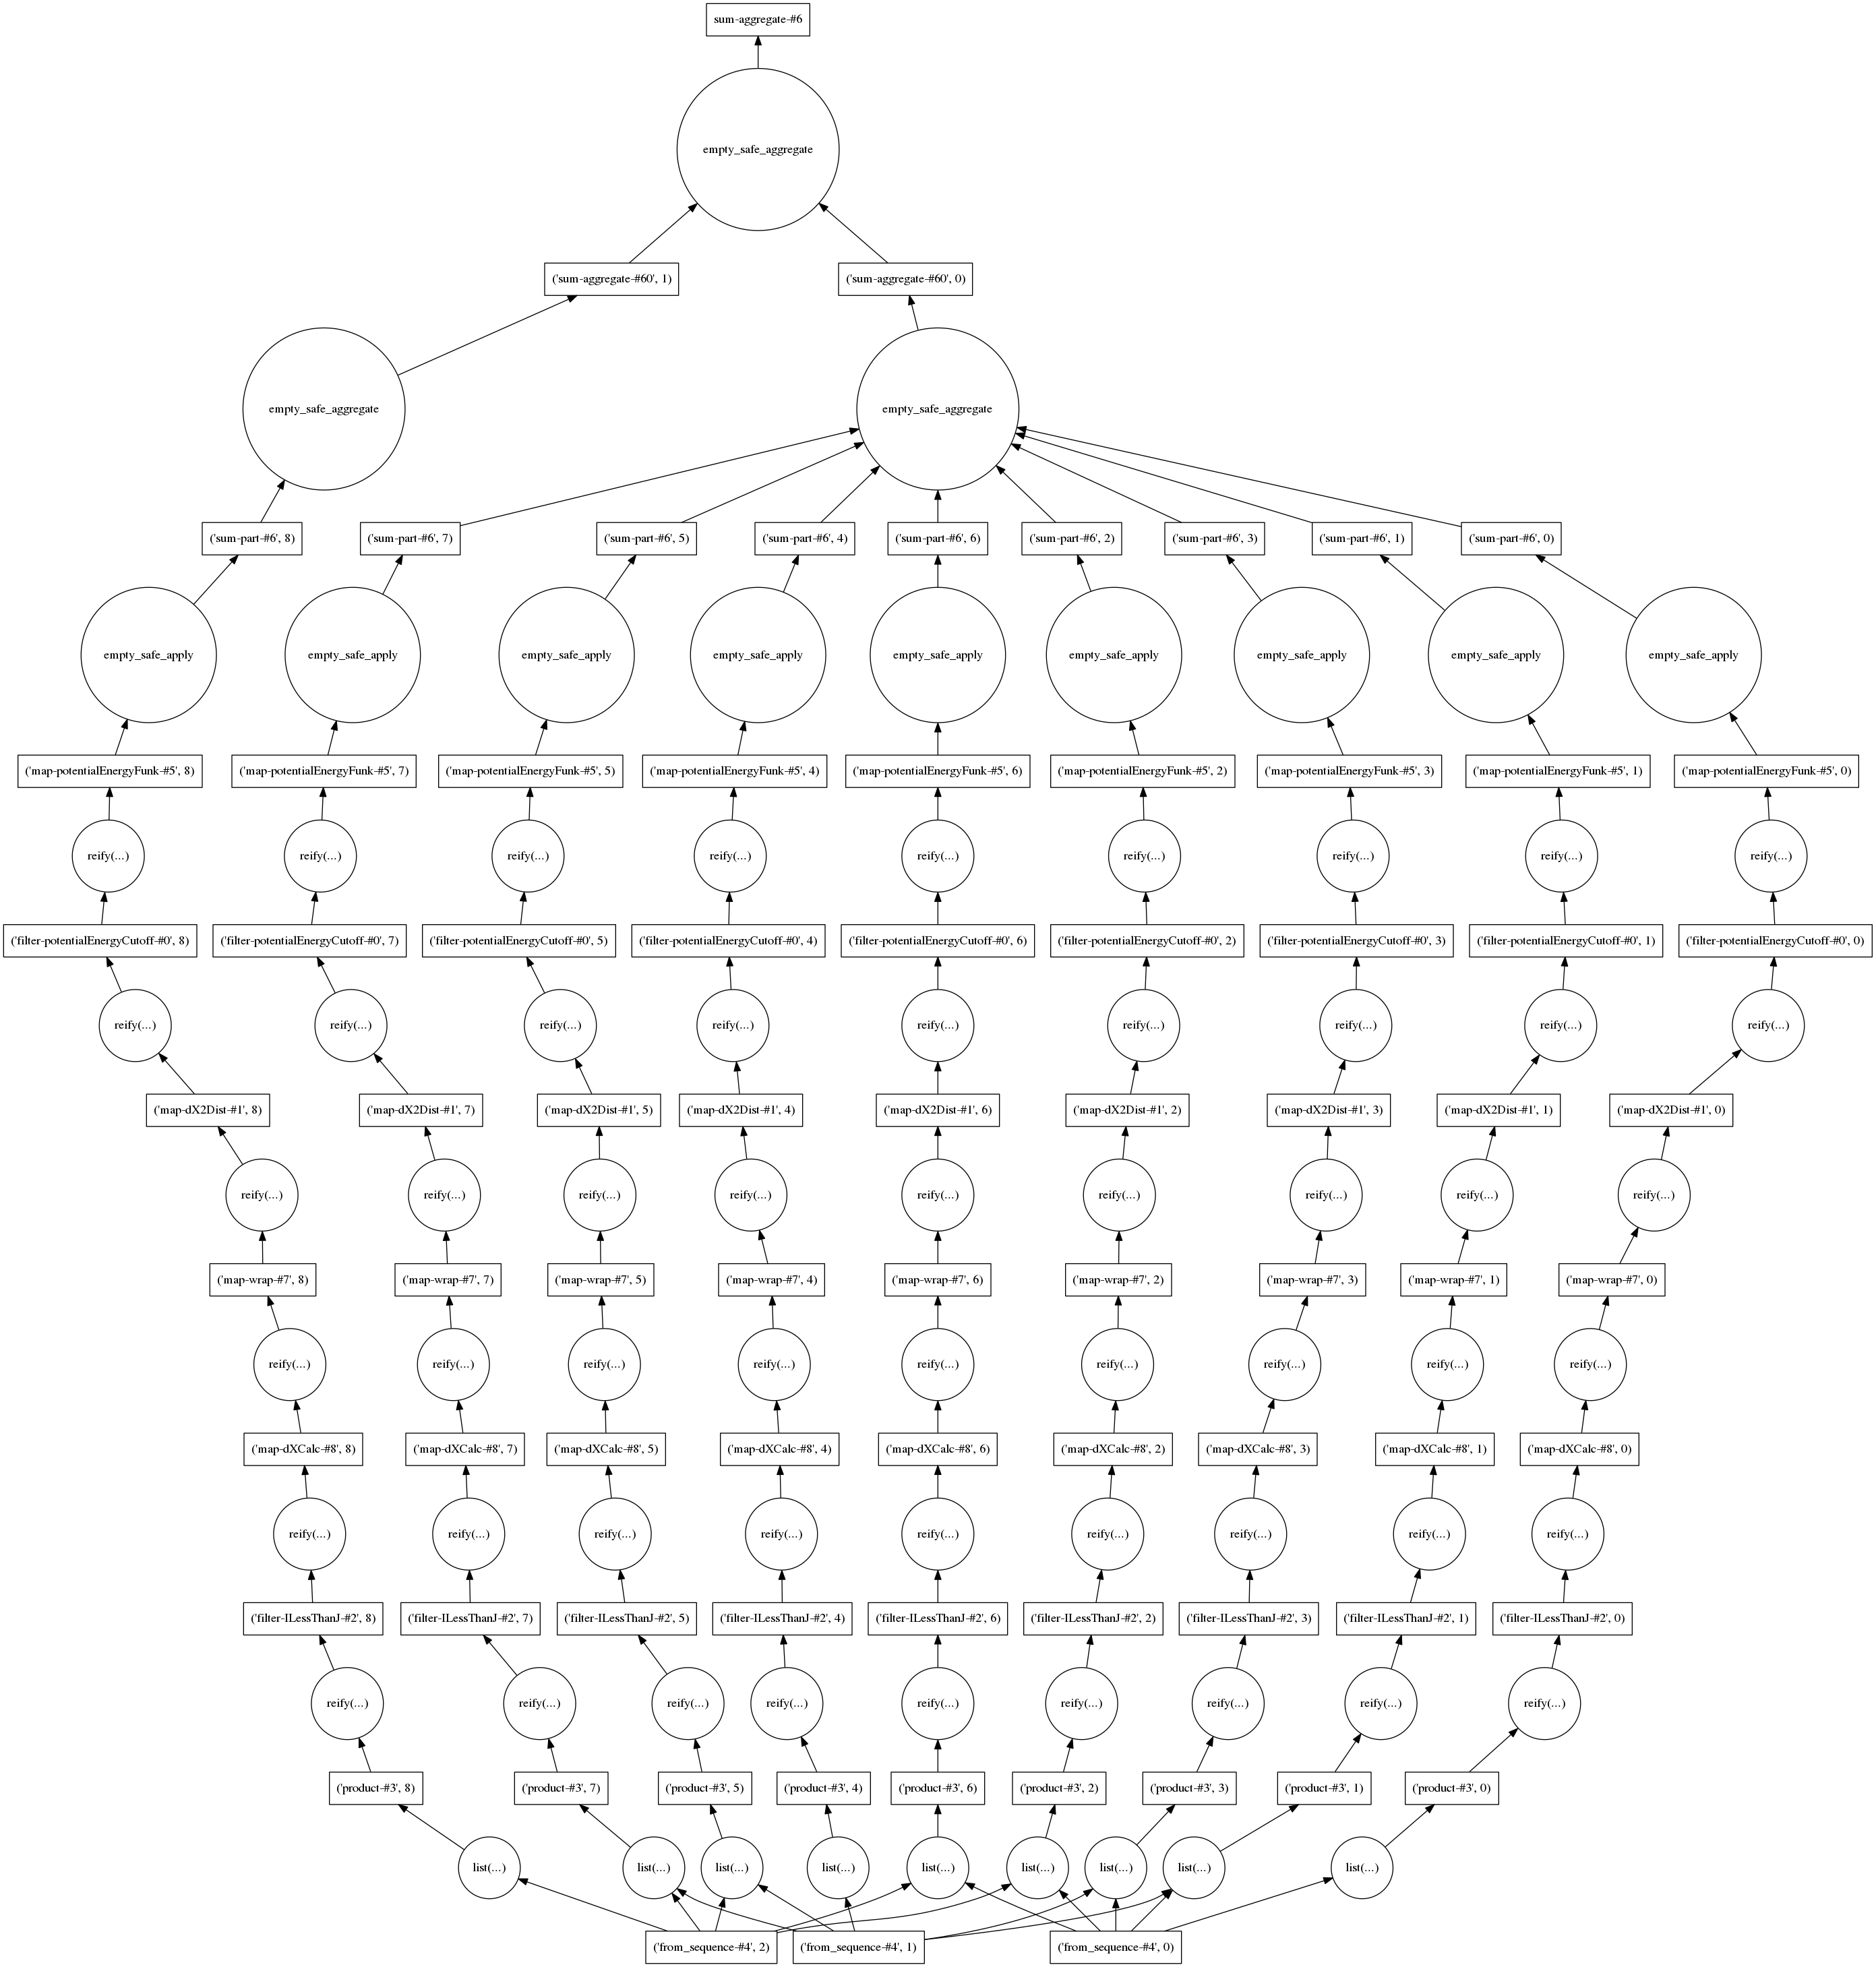

In [4]:
#Warning! only run this with number of positions set to ~3
#If you set up your environment via conda, you'll have to install the graphviz python
#interface 'manually' via pip:
#  source activate peopt
#  pip install graphviz

future.visualize()

## Round 1: Dask Bag

In [5]:
import numpy as np
pos = np.loadtxt('data/positions.dat')
box = np.loadtxt('data/box.dat')

lx = box[0]
ly = box[1]
lz = box[2]
lx2 = box[0]/2.0
ly2 = box[1]/2.0
lz2 = box[2]/2.0

print('Read {:d} positions.'.format(pos.shape[0]))
print('x min/max: {:+4.2f}/{:+4.2f}'.format(pos.min(0)[0],pos.max(0)[0]))
print('y min/max: {:+4.2f}/{:+4.2f}'.format(pos.min(0)[1],pos.max(0)[1]))
print('z min/max: {:+4.2f}/{:+4.2f}'.format(pos.min(0)[2],pos.max(0)[2]))

Read 5000 positions.
x min/max: -24.99/+24.97
y min/max: -25.00/+24.99
z min/max: -25.00/+24.99


In [6]:
from math import cos,pi,sqrt
import numpy as np
import dask.bag as db
import dask

def potentialEnergyFunk(r,width=1.0,height=10.0):
    '''
    Calculates the (soft) potential energy between two atoms
    
    Parameters
    ----------
    r: float
        separation distance between two atoms
    height: float
        breadth of the potential i.e. where the potential goes to zero
    width: float
        strength/height of the potential
    '''
    if r<width:
        return 0.5 * height * (1 + cos(pi*r/width))
    else:
        return 0
    

def wrap(x):
    x = abs(x)
    if x[0]>lx2:
        x[0]-=lx
    if x[1]>ly2:
        x[1]-=ly
    if x[2]>lz2:
        x[2]-=lz
    return x

def ILessThanJ(ij):
    return ij[0]<ij[1]

def dXCalc(ij):
    return pos[ij[0]] - pos[ij[1]]

def dX2Dist(x):
    return sqrt(x[0]*x[0] + x[1]*x[1] + x[2]*x[2])

def potentialEnergyCutoff(x,width=1.0):
    return x<width


In [ ]:
%%prun -D prof/dask.prof

bag = db.from_sequence(np.arange(pos.shape[0]))

future = (bag.product(bag)                   #produce all i-j pairs                                 
             .filter(ILessThanJ)             #we only need the i<j pairs
             .map(dXCalc)                    #convert the i-j pair to a dx,dy,dz
             .map(wrap)                      #need to wrap for box boundaries
             .map(dX2Dist)                   #convert wrapped dx,dy,dz to distance
             .filter(potentialEnergyCutoff)  #distance cutoff
             .map(potentialEnergyFunk)       #potential energy calculation
             .sum()
         )
          
energy = future.compute(get=dask.threaded.get)
energy

In [ ]:
bag = db.from_sequence(np.arange(pos.shape[0]))

future = (bag.product(bag)                   #produce all i-j pairs                                 
             .filter(ILessThanJ)             #we only need the i<j pairs
             .map(dXCalc)                    #convert the i-j pair to a dx,dy,dz
             .map(wrap)                      #need to wrap for box boundaries
             .map(dX2Dist)                   #convert wrapped dx,dy,dz to distance
             .filter(potentialEnergyCutoff)  #distance cutoff
             .map(potentialEnergyFunk)       #potential energy calculation
             .sum()
         )
          


memprof = %memit -o  future.compute(get=dask.threaded.get)

usage = memprof.mem_usage[0]
incr = memprof.mem_usage[0] - memprof.baseline
with open('prof/dask.memprof','w') as f:
    f.write('{}\n{}\n'.format(usage,incr))